# Хакатон Яндекс Практикум и Яндекс Музыка

**Основные задачи Хакатона**

Необходимо разработать ML-продукт, который:

- Может классифицировать треки по признаку кавер-некавер
- Находит все кавер-треки и/или исходники к заданному треку в датасете
- Перечисляет все кавер-треки и/или оригиналы к заданному, указывает положение данного трека в цепочке каверов

Для решения этой задачи можно использовать любые открытые источники данных и собирать необходимую информацию, соблюдая правила использования сервисов, которые эту информацию предоставляют.

**Данные**

**Разметка каверов**

Разметка каверов сделана редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

<aside>
💡 Внимание: не для всех каверов известны идентификаторы исходных треков!
</aside>

**Метаинформация**

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

**Текст песен**

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## Импорты необходимых библиотек

**Requirments**

- os
- re
- gc
- PIL
- colorama
- numpy
- pandas
- matplotlib
- seaborn
- tqdm
- langdetect
- lyricsgenius
- musicbrainzngs
- sklearn
- torch
- optuna
- lightgbm
- sentence_transformers

**Импорты необходимых библиотек**

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import gc
import pickle
import re
import joblib
import requests

from tqdm import notebook, tqdm
from pandarallel import pandarallel
from colorama import Fore, Style

from langdetect import LangDetectException, detect
import lyricsgenius
import musicbrainzngs
from PIL import Image

import optuna
from optuna.pruners import HyperbandPruner
from optuna.samplers import TPESampler

from lightgbm import LGBMClassifier

import torch
from sentence_transformers import SentenceTransformer, util

from sklearn.metrics import (
    auc,
    confusion_matrix,
    make_scorer,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

RANDOM = 12345
torch.manual_seed(RANDOM)
np.random.seed(RANDOM)

**Путь к файлам**

In [2]:
work_dir = os.path.abspath(os.curdir)
print("Текущая деректория:", work_dir)

meta_json = "meta.json"
lyrics_json = "lyrics.json"
covers_json = "covers.json"

Текущая деректория: /home/andreivk/Projects/Jupyter/Yandex Music Hacaton


## Функции для работы

В данном проекте нашей командой мы постарались применить максимально функцианольный подход к решению задач. Все функции содержат докстрингу, которая описывает суть функции, входные параметры, возвращаемые значения и комменты к коду, где это реально необходимо.

**Функция для загрузки датасета**

In [3]:
def get_first_dataset(work_dir, meta_json, lyrics_json, covers_json):

    """
    Функция загрузки первичного датасета.

    Параметры:

     work_dir: папка с файлами json, в которых содержатся данные.
     meta_json, lyrics_json, covers_json: файлы с данными

    Возвращаемое значение:

     data: объединенный датасет из файлов meta_json, lyrics_json, covers_json по ключу 'track_id'

    """
    # загрузка метаданных
    meta = pd.read_json(os.path.join(work_dir, meta_json), orient="columns", lines=True)
    # загрузка имеющихся в наличии текстов песен
    lyrics = pd.read_json(
        os.path.join(work_dir, lyrics_json), orient="columns", lines=True
    )
    # загрузка разметки
    covers = pd.read_json(
        os.path.join(work_dir, covers_json), orient="columns", lines=True
    )
    # объединение covers и meta
    data = pd.merge(covers, meta, how="left", on=["track_id"])
    # объединение data и lyrics
    data = pd.merge(data, lyrics[["text", "track_id"]], how="left", on=["track_id"])

    print(f"Датасет сформирован")
    return data

**Функция проверки загрузки**

In [4]:
def display_dataset_info(dataset):

    """
    Функция проверки загрузки: вывод первых 5 строк, информации о датафрейме и наличии дубликатов.

    Параметры:

     dataset: исследуемый датасет.

    Возвращаемое значение:

     Первые 5 строк датафрейма, метод .info() и метод .describe(include="all")
    """
    print("-" * 35 + "SAMPLE" + "-" * 35)
    display(dataset.head())
    print()
    print("-" * 36 + "INFO" + "-" * 36)
    print()
    display(dataset.info())
    print("-" * 34 + "DESCRIBE" + "-" * 34)
    display(dataset.describe(include="all"))

**Функция парсинга текста**

Функция принимает на вход датасет с треками. 

Поиск текста осущетсвляется через API genius.com. 

Если текста нет в датасете, то происходит обращение к сайту и по имени трека ищется текст. Если текст есть в базе сайта, то возращается найденный текст. Если текста нет в базе сайта или выдается ошибка формирования запроса, то возвращается значение "No text". При наличии тескта в датасете, текст оставляется.

In [5]:
def parse_text(data):

    """
    Функция для парсинга отсутсвующих текстов.

    Параметры:

     data: исходный датасет

    Возвращаемое значение:

     - lyrics, если он есть в базе genius.com;
     - 'No text', если текста нет в базе genius.com;
     - data["text"], если текст есть в датасете.

    """

    # проверка на пропуск текста
    if pd.isnull(data["text"]):
        try:
            # запрос к genius.com по названию трека
            song = genius.search_song(data["title"], get_full_info=False)
            # провека есть ли текст в базе сайта и запись текста в датасет
            if song:
                lyrics = song.lyrics
                return lyrics
            # если текста в базе сайта нет возврат "No text"
            else:
                return "No text"
        # возможна ошибка на самом сайте, неправильное формирование поиска сайтом - возврат "No text"
        except:
            print("Ошибка сайта, пропускаем трек")
            return "No text"
    # если текст есть в датасете возвращаем текст из датасета
    return data["text"]

**Функция обработки датасета**

Функция выполняет следующие этапы обработки:

- удаление дубликатов по коду `isrc`,
- удаление лишних столбцов: `original_track_id`, `track_id` и `language`,
- удаляются строки с пропусками,
- очистка тестов песен,
- детекция языка по тексту песни,
- извлечение года регистрации трека из кода `isrc`, 
- распаковка жанров,
- вывод информации по балансу классов.

In [6]:
def preprocess_dataset(data=None):

    """
    Функция обработки датасета.

    Параметры:

     data: исходный датасет

    Возвращаемое значение:

     data: обработанный датасет

    """

    # Удаляем дубликаты по isrc
    data = data.drop_duplicates(subset=["isrc"])
    print(f"Дубликаты записей с одинаковым кодом isrc удалены.")
    # Удаляем ненужные столбцы
    data = data.drop(["original_track_id", "track_id", "language"], axis=1)
    # Удаляем пропуски
    print(
        f"Удалены не нужные в дальнейшем столбцы: 'original_track_id', 'track_id', 'language'"
    )
    data = data.dropna()
    # Очистка текста
    print(f"Пропуски удалены.")
    tqdm.pandas(desc="Очистка текста.")
    data["text"] = data["text"].progress_apply(clean_text)
    # Детекция языка по тексту песни
    tqdm.pandas(desc="Определение языка.")
    data["language_text"] = data["text"].progress_apply(detect_language)
    # Вытаскиваем год регистрации трека из isrc
    tqdm.pandas(desc="Вытаскиваем год регистрации трека из isrc")
    data["year"] = data["isrc"].progress_apply(extract_year_from_isrc)
    # вызов функции unpack_list для распаковки жанров
    tqdm.pandas(desc="Распаковка списков в столбце genres.")
    data["genres"] = data["genres"].progress_apply(unpack_list)
    # Баланс классов
    print(f"Баланс классов:\n{data['track_remake_type'].value_counts(normalize=True)}")
    # Перекодировка таргета в 0 и 1
    data["track_remake_type"] = data["track_remake_type"].map(
        {"ORIGINAL": 1, "COVER": 0}
    )
    # Графическая интерпретация баланса классов оригиналов и каверов.
    plt.figure(figsize=(12, 7))
    plt.title("Целевой признак", fontsize=18)
    ax = sns.barplot(
        x=data["track_remake_type"].unique(),
        y=data["track_remake_type"].value_counts(normalize=True),
        palette=["green", "red"],
    )

    plt.xlabel("Оригиналы и каверы", fontsize=15)
    plt.ylabel("Процентное соотношение", fontsize=15)
    plt.xticks(ticks=[1, 0], labels=["COVER", "ORIGINAL"])

    plt.show()
    # порядок колонок в удобном виде
    cols = [
        "isrc",
        "title",
        "genres",
        "year",
        "language_text",
        "dttm",
        "duration",
        "text",
        "track_remake_type",
    ]
    data = data[cols]
    # категориальные столбцы в тип категорию
    cat_features = ["isrc", "title", "genres", "year", "language_text"]
    data[cat_features] = data[cat_features].astype("category")

    print("Обработка завершена")

    return data

**Функция распаковки списка с жанрами в строку**

Жанры представлены в виде списков, например ["POP", "ELECTRONIC"]. Данная функция распакует списки и выдаст результат:

- "UNKNOWN", если в данных пропуск или пустой список;
- выдаст нулевой элемент, если в списке только один элемент;
- сджойнит в строку, если в списке 2 и более элементов.

Данная функция будет вызвана внутри функции `preprocess_dataset`.

In [7]:
def unpack_list(row):

    """
    Функция для распаковки значений списка в столбце genres в датасете meta.

    Параметры:

     row: жанры представленны в виде списка, например ["POP", "ELECTRONIC"]

    Возвращаемое значение:

     - "UNKNOWN", если в данных пропуск или пустой список;
     - row[0], если в списке только один элемент;
     - ", ".join(row), если в списке 2 и более элементов.

    """
    # проверка на пропуск
    if row is None:
        return "UNKNOWN"
    # проверка на пустой список
    elif len(row) == 0:
        return "UNKNOWN"
    # проверка на 1 элемент
    elif len(row) == 1:
        return row[0]
    # проверка на 2 и более элементов в списке
    else:
        return ", ".join(row)

**Функция очистки текста**

Данная функция будет вызвана внутри функции `preprocess_dataset`.

Функция очищает текст песни и проводит его в читабельный вид. Все делается при помощи регулярных выражений.

In [8]:
def clean_text(text):

    """
    Функция очистки текста.

    Параметры:

     text: исходный текст

    Возвращаемое значение:

     txt: обработанный текст

    """

    # тексте иногда встречаются 1 или две цифры в начале строки - их убираем
    if text[0].isdigit() and text[1].isdigit():
        text = text[2:]
    elif text[0].isdigit():
        text = text[1:]

    txt = re.sub(
        r"\[[^\]]*\]", r" ", text
    )  # комменты в квадратных скобках (например [Intro]) меняем на пробел
    txt = re.sub(
        r"\([^)]*\)", r" ", txt
    )  # комменты в круглых скобках со звездочками (например (*Whistling*)) меняем на пробел
    txt = re.sub(
        r"(C|c)ontributor(s|)([^;]*)((L|l)yrics|(V|v)(S|s))", r" ", txt
    )  # шаблон поиска и замены между contributors ... lyrics с захватом самих слов и аналогичных
    txt = re.sub(r"[\.]+", r".", txt)  # многоточие меняем на точку
    txt = re.sub(
        r"[^\w\d'\s]", r"", txt
    )  # оставшиеся знаки препинания кроме апострофа на пустую строку
    txt = re.sub(
        "\n", r" ", txt
    )  # оставшиеся знаки препинания кроме апострофа на пустую строку
    txt = re.sub(r"([ ])\1", r" ", txt)  # повторяющиеся пробелы меняем на один пробел
    txt = txt.lstrip()  # обрезка пробелов слева
    txt = txt.rstrip()  # обрезка пробелов справа

    # текст в нижний регистр
    txt = txt.lower()

    return txt

**Функция детекции языка по тексту песни**

Данная функция будет вызвана внутри функции `preprocess_dataset`.

При помощи пакета `langdetect` определяется язык текста песни.

In [9]:
def detect_language(text):

    """
    Функция детекции языка текста, применяется к столбцу с текстом песни.
    Для детекции используется модуль langdetect.

    Параметры:

     text: исходный текст

    Возвращаемое значение:

     - 'UNKNOWN', если язык не определен;
     - language, если язык определен;

    """
    try:
        language = detect(text).upper()
    except LangDetectException:
        language = (
            "UNKNOWN"  # Язык по умолчанию для случаев, когда определение не удалось
        )
    return language

**Функция извлечения года из кода isrc**

Данная функция будет вызвана внутри функции `preprocess_dataset`.

Код `isrc` имеет формат вида: `GBF089190020` или `QMKHM1900102` . Год гачинается либо с 5-го символа, либо в некоторых с 6-го. 

К году конкатенируется спереди 20 или 200, если это двух тысячные с 0-го по 23-й год. В остальных случаях конкатенируется 19 и цифры года.

In [10]:
def extract_year_from_isrc(row):

    """
    Функция извлечения года регистрации,применяется к столбцу с кодом isrc.

    Параметры:

     row: код isrc

    Возвращаемое значение:

     final_year: год в типе int.

    """
    # список для двухтысячных годов с 0-го по 23-й
    twenties = [i for i in range(0, 24)]

    # есть коды, в которых присутсвуют дефисы - дефисы убираем, стандарная длина кода 12 символов
    if len(row) > 12:
        row = row.replace("-", "")
    # в некоторых кодах год начинается с 5-го символа, в некоторых с 6-го. Извлекаем год в виде двух
    # символов, например '00' или "22"
    if row[5].isalpha():
        year = int(row[6:8])
    else:
        year = int(row[5:7])

    final_year = ""

    # так как год имеет два символа, то как факт можно принять, что с 00 по 23 это двухтысячные годы,
    # а остальные это 19 + символы года.
    # проверка, что год в двухтысячных
    if year in twenties:
        year = str(year)
        # если год от 0 до 9, то конкатенируем '200' и цифру года, переводив в тип int
        if len(year) == 1:
            final_year = "200" + year
            return int(final_year)
        # если год от 10, то конкатенируем '20' и цифру года, переводив в тип int
        else:
            final_year = "20" + year
            return int(final_year)
    # если год от 24 до 99, то конкатенируем '19' и цифру года, переводив в тип int
    else:
        year = str(year)
        final_year = "19" + year
        return int(final_year)

**Функция разбиения на выборки**

Данная функция будет вызвана внутри функции `get_selections`.

Функция позволяет разбивать выборку на тренировочную, тестовую или тренировочную, валидационную итестовую.

In [11]:
def data_split(
    dataset,
    target_col=None,
    test_size=0.2,
    valid=False,
    test_valid_size=0.4,
    report=False,
):
    """
    Функция разбивает датасет на выборки.

    Параметры:

     data: датасет с данными,
     test_size: размер тестовой выборки, по умолчанию 20% или 0.2,
     valid: флаг для выбора возможности добавлять валидационную выборку,
     test_valid_size: размер тестовой и валидационной выборки, по умолчанию 40% или 0.4, в дальнейшем
                      выборки будут разбиты 50 на 50.

    Возвращаемое значение (результат разбиения на выборки):

     Если valid=False, возвращаются только трейн и тест:

       features_train, target_train, features_test, target_test

     Если valid=True, возвращаются трейн, валид и тест:

       features_train, target_train, features_valid, target_valid, features_test, target_test

    """

    # выделение признаков
    features = dataset.drop([target_col], axis=1)
    # выделение целевого признака
    target = dataset[target_col]

    # если нужна валидация - разбиваем на train, valid, test в соотношении 60-20-20
    if valid:

        features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=test_valid_size, random_state=RANDOM
        )
        features_valid, features_test, target_valid, target_test = train_test_split(
            features_test, target_test, test_size=0.5, random_state=RANDOM
        )

        if report:

            print("Тренировочная выборка: ", features_train.shape, target_train.shape)
            print("Валидационная выборка: ", features_valid.shape, target_valid.shape)
            print("Тестовая выборка: ", features_test.shape, target_test.shape)

        return (
            features_train,
            target_train,
            features_valid,
            target_valid,
            features_test,
            target_test,
        )

    # если не нужна валидация - разбиваем на train и test в соотношении 80-20
    else:

        features_train, features_test, target_train, target_test = train_test_split(
            features, target, test_size=test_size, random_state=RANDOM
        )

        if report:
            print("Тренировочная выборка: ", features_train.shape, target_train.shape)
            print("Тестовая выборка: ", features_test.shape, target_test.shape)

        return features_train, target_train, features_test, target_test

**Функция получения масштабированных выборок**

Функция позволяет получать масштабированные выборки и удалять не нужные столбцы в выборках.

In [12]:
def get_selections(dataset=None, 
                   target_col=None, 
                   cols_to_drop=None,
                   test_size=0.25,
                   valid=False,
                   test_valid_size=0.4):

    """
    Функция получения масштабированных выборок.

    Параметры:

     dataset: датасет с данными, по умолчанию None,
     target_col: целевой признак, по умолчанию None,
     cols_to_drop: список со столбцами для удаления из выборок если это требуется, по умолчанию None.
     test_size: размер тестовой выборки, по умолчанию 25% или 0.25,
     valid: флаг для выбора возможности добавлять валидационную выборку,
     test_valid_size: размер тестовой и валидационной выборки, по умолчанию 40% или 0.4, в дальнейшем
                      выборки будут разбиты 50 на 50.

    Возвращаемое значение (масштабированные выборки и таргеты):

     Если valid=False, возвращаются только трейн и тест:

       features_train, target_train, features_test, target_test

     Если valid=True, возвращаются трейн, валид и тест:

       features_train, target_train, features_valid, target_valid, features_test, target_test

    """
    # вызов фунции data_split для разбиения на выборки
    
    if valid:
        features_train, target_train, features_valid, target_valid, features_test, target_test = data_split(
            dataset, target_col=target_col, test_size=test_valid_size, report=False, valid=valid
        )
    else:
        features_train, target_train, features_test, target_test = data_split(
            dataset, target_col=target_col, test_size=test_size, report=False, valid=valid 
        )
    # проверка наличия списка удаляемых столбцов из выборок
    if cols_to_drop:
        # удаление из трейна и теста нужных столбцов
        features_train = features_train.drop(cols_to_drop, axis=1)
        features_test = features_test.drop(cols_to_drop, axis=1)
        if valid:
            features_valid = features_valid.drop(cols_to_drop, axis=1) 

    # масштабирование числовых признаков
    # получиение списка числовых признаков
    num_cols = features_train.select_dtypes(include=np.number).columns.tolist()
    if len(num_cols) > 0:
        # объявление шкалера и его обучение на трейне
        scaler = StandardScaler()
        scaler.fit(features_train[num_cols])
        # масштабирование числовых признаков в трейне и тесте
        features_train[num_cols] = scaler.transform(features_train[num_cols])
        features_test[num_cols] = scaler.transform(features_test[num_cols])
        if valid:
            features_valid[num_cols] = scaler.transform(features_valid[num_cols])

    # возврат выборок и таргетов
    if valid:
        return features_train, target_train, features_valid, target_valid, features_test, target_test
    return features_train, target_train, features_test, target_test

**Функция `objective` поиска лучших гиперпараметров для модели**

Чтобы использовать `Optuna`, сначала нужно создать целевую функцию. Она включает в себя словарь гиперпараметров модели, которые необходимо протестировать. `Optuna` выполнит серию запусков и протестирует различные комбинации гиперпараметров, подогнав их к модели, а затем измерит метрику , прежде чем окончательно вернет наилучшие параметры.

In [13]:
def objective(trial):

    """
    Функция поиска лучших гиперпараметров для модели.

    Возвращаемое значение (метрика):

     roc_auc_scores

    """
    # гиперпараметры для перебора
    params = {
        "objective": trial.suggest_categorical(
            "objective", ["binary"]
        ),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["gbdt", "rf"]
        ),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 25),
        "num_leaves": trial.suggest_int("num_leaves", 2, 25),
        "min_child_weight": trial.suggest_float("min_child_weight", 5, 25),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "pos_subsample": trial.suggest_float("pos_subsample", 0.8, 0.9),
        "neg_subsample": trial.suggest_float("neg_subsample", 0.5, 0.8),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 6, 10)
    }

    # инициализация модели
    model = LGBMClassifier(**params, random_state=RANDOM, n_jobs=-1, verbose=-1)
    
    # получение метрики на кроссвалидации
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM, shuffle=True)
    roc_auc_scores = cross_val_score(
        model, features_train, target_train, cv=skf, scoring="roc_auc"
    ).mean()
    # возврат метрики
    return roc_auc_scores

**Функция для получения обученной модели на лучших гиперпараметрах**

Чтобы запустить исследование `Optuna` и определить наилучшие гиперпараметры для модели `LightGBMClassifier`, нужно создать сэмплер. Будет использован `TPESampler`, который использует алгоритм оценки `Parzen` с древовидной структурой. Необходимо максимизировать точность модели во время настройки, поэтому нужно передать `maximize` аргумент в `create_study()` вместе с созданным сэмплером `sampler`. Затем нужно использовать `optimize()` для запуска необходимого количества тестов (`n_trial`).

In [14]:
def get_model_with_best_params(n_trials=10, features_train=None, target_train=None):

    """
    Функция для получения обученной модели на лучших гиперпараметрах.

    Параметры:

     n_trials: количество тестов модели, по умолчанию 10,
     features_train: признаки для облучения, по умолчанию None,
     target_train: целевой признак для обучения, по умолчанию None.

    Возвращаемое значение (обченная модель на лучших гиперпараметрах):

     model

    """
    # создание сэмплера
    pruner = HyperbandPruner()
    sampler = TPESampler(seed=RANDOM)
    # инициализация подбора гиперпараметров
    study = optuna.create_study(
        study_name="lightgbm", direction="maximize", pruner=pruner, sampler=sampler
    )
    # процесс подбора гиперпараметров
    study.optimize(objective, n_trials=n_trials)

    # вывод на экран результатов
    print()
    print("Лучшие гиперпараметры подобраные Optuna:", study.best_params)
    print(
        "Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалидацией:",
        study.best_value,
    )

    # инициализация модели с лучшими гиперпараметрами
    model = LGBMClassifier(
        **study.best_params, random_state=RANDOM, n_jobs=-1, verbose=-1
    )

    # обучение модели
    model.fit(features_train, target_train)
    print(f"Модель LGBMClassifier обучена.")

    # возврат модели
    return model

**Функция для вывода метрики на тестовой выборке**

In [15]:
def get_test_metric(model=None, features_test=None, target_test=None):

    """
    Функция для для вывода метрики на тестовой выборке.

    Параметры:

     model: модель, по умолчанию None,
     features_train: признаки для прогнозирования - тестовая выборка, по умолчанию None,
     target_train: целевой признак прогнозирования - тестовая выборка, по умолчанию None.

    Возвращаемое значение:

     Нет возвращаемого значение, только вывод результатов по метрикам.

    """
    # вызов метода predict_proba
    predicted_probalities_test = model.predict_proba(features_test)[:, 1]
    # подсчет roc_auc
    best_roc_auc_test = roc_auc_score(target_test, predicted_probalities_test)
    # вывод на экран
    print(f"Метрика AUC-ROC модели на тестовой выборке: {best_roc_auc_test:.4f}")

    # precision, recall для подсчета PR AUC
    precision, recall, _ = precision_recall_curve(
        target_test, predicted_probalities_test
    )
    # подсчет PR AUC
    pr_auc = auc(recall, precision)
    # вывод на экран
    print("PR AUC: ", pr_auc)

**Функция для построения pr-кривой и нахождения лучшего трешхолда**

In [16]:
def drow_pr_curve(features, target, best_model, treshold=False):
    """
    Функция для построения pr-кривой и нахождения лучшего трешхолда.

    Параметры:

     features: признаки модели
     target: столбец с целевым признаком
     treshold: параметр для инизиализации лучшего treshold, рекомендуется только для train, по умолчанию True.

    """

    target_score = best_model.predict_proba(features)[:, 1]

    precision, recall, thresholds = precision_recall_curve(target, target_score)

    if treshold:

        fscore = (2 * precision * recall) / (precision + recall)

        ix = np.argmax(fscore)

        best_treshold = thresholds[ix]

        print("Лучший Threshold = %.2f" % best_treshold)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, color="purple", label="Модель")

    if treshold:

        ax.scatter(
            recall[ix],
            precision[ix],
            marker="o",
            color="black",
            label="Лучший Threshold",
        )

    ax.set_title("Precision-Recall Curve")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.legend()

    plt.show()

**Функция для построения матрицы ошибок**

In [17]:
def drow_confusion_matrix(conf_matrix):
    """
    Функция для построения матрицы ошибок.

    Параметры:

     conf_matrix: матрица ошибок.

    """

    plt.figure(figsize=(12, 8))

    classes = ["True Negative", "False Positive", "False Negative", "True Positive"]

    values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]

    percentages = [
        "{0:.1%}".format(x) for x in conf_matrix.flatten() / np.sum(conf_matrix)
    ]

    combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
    combined = np.asarray(combined).reshape(2, 2)

    ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap="YlGnBu")

    ax.set(title="Confusion Matrix")
    ax.set(xlabel="Predicted", ylabel="Actual")

    plt.show()

**Функция для интерпретации результатов матрицы ошибок**

In [18]:
def conf_matrix_result(conf_matrix):
    """
    Функция для интерпретации результатов матрицы ошибок.

    Параметры:

     conf_matrix: матрица ошибок

    Выводит на экран:

     - количество предсказаний,
     - accuracy,
     - долю ошибок,
     - recall,
     - precision,
     - отчет по матрице ошибок.

    """

    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    total = TN + TP + FP + FN

    acc = round((TP + TN) / total, 4)
    recall = round(TP / (TP + FN), 4)
    precision = round(TP / (TP + FP), 4)

    print(f"Всего предсказаний: {total}\n")

    print(f"Правильно предсказанные ответы (Accuracy): {acc}")
    print(f"Ошибки в прогнозах: {round(1 - acc, 4)}\n")

    print(f"Recall: {recall}")
    print(f"Precision: {precision}\n")

    print(f"Доля ошибок в оригиналах FN/TP: {FN/TP:.2f}")
    print(f"Доля ошибок в каверах FP/TN: {FP/TN:.2f}\n")

    print(
        f"1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:\n"
    )
    print(
        f"  - TN в левом верхнем углу. {TN} правильных ответов. Кавер определен правильно."
    )
    print(
        f"  - TP в правом нижнем углу. {TP} правильных ответов. Оригинал определен правильно.\n"
    )
    print(f"2. Вне главной диагонали — ошибочные варианты:\n")
    print(
        f"  - FP в правом верхнем углу. {FP} ошибок ошибочных предсказаний первого рода. Кавер определен как оригинал."
    )
    print(
        f"  - FN в левом нижнем углу. {FN} ошибочных предсказаний второго рода. Оригинал определен как кавер."
    )

**Функция поиска оригинала и каверов при наличии их в датасете**

Данная функция будет вызывать внутри себя несколько промежуточных функций.

***Функция получения текста трека***

Данная функция будет вызвана внутри функции `search_covers`.

In [19]:
def get_track_text(song_name=None, dataset=None):
    """
    Функция получения текста трека.

    Параметры:

     song_name: название трека, по умолчанию None,
     dataset: датасет с треками, по умолчанию None.

    Возвращаемое значение:

     text: текст песни.

    """


    # проверка наличия трека в датасете
    if song_name.lower() not in list(dataset["title"].str.lower()):
        # возврат отчета об отсутствии трека в датасете
        return print(f"Трека: {song_name} нету в тестовой выборке..")
    # получаем из датасета текст песни
    text = (
        dataset.loc[dataset["title"].str.lower() == song_name.lower(), "text"]
        .reset_index()
        .iloc[0, 1]
    )

    return text

***Функция получения индексов треков с максимально близким семантичеким значение текстов в датасете***

Данная функция будет вызвана внутри функции `search_covers`.

Функция получает индексы максимально близких текстов по семантике используя метод `util.semantic_search`. 

In [20]:
def get_idx_songs(model_trasformer=None, embedding_all_texts=None, text=None, device="cpu"):
    """
    Функция получения индексов треков с максимально близким семантичеким значение текстов в датасете.

    Параметры:

     embedding_all_texts: векторизованные тексты по всему датасету, по умолчанию None,
     device: GPU или CPU, по умолчанию "cpu",
     model_trasformer: модель SentenceTransformer, по умолчанию None,

    Возвращаемое значение:

     lst_idx: индексы треков с максимально близким семантичеким значение текстов в датасете.

    """

    # веторизируем его
    embedding_text = model_trasformer.encode(text, device=device, batch_size=1)
    # получение информации по близости векторов
    score = util.semantic_search(embedding_text, embedding_all_texts, top_k=10)[0]
    # остекаем тексты с близостью менее 0.95
    lst_idx = [
        score[i]["corpus_id"] for i in range(len(score)) if score[i]["score"] >= 0.95
    ]

    return lst_idx

***Функция получения информации о треке по коду `isrc` c сайта `musicbrainzngs`***

Данных к сожалению может не быть на сайте.

Данная функция будет вызвана внутри функции `get_dataset_for_track`.

In [21]:
def get_track_info_from_musicbrainzngs(dataset=None):
    """
    Функция получения информации о треке по коду isrc c сайта musicbrainzngs.

    Параметры:

     dataset: датасет с треками, по умолчанию None.

    Возвращаемое значение:

     names: список с исполнителями.

    """

    # ищем имя исполнителя на сайте musicbrainzngs
    musicbrainzngs.set_useragent("Данные скрыты: конфиденциальная информация")

    names = []
    for item in list(dataset["isrc"]):
        try:
            name = musicbrainzngs.get_recordings_by_isrc(item, includes=["artists"])
            # получение имени исполнителя
            res = name["isrc"]["recording-list"][0]["artist-credit"][0]["artist"][
                "name"
            ]
            names.append(str(res))
        except:
            names.append("Unknown")

    return names

***Функция формирования датасета с каверами и оригиналами, информацией о них и классификационнным прогнозом***

Данная функция будет вызвана внутри функции `search_covers`.

In [22]:
def get_dataset_for_track(dataset=None, lst_idx=None, model_predictor=None):
    """
    Функция формирования датасета с каверами и оригиналами, информацией о них и классификационнным прогнозом

    Параметры:

     dataset: датасет с треками, по умолчанию None,
     lst_idx: индексы треков с максимально близким семантичеким значение текстов в датасете, по умолчанию None,
     model_predictor: модель для пресказания кавер или оригинал, по умолчанию None.

    Возвращаемое значение:

     data_temp: датасет с каверами и оригиналами, информацией о них и классификационнным прогнозом.

    """

    data_temp = dataset.copy(deep=True)

    data_temp = dataset.iloc[lst_idx]
    # создаем признаки для предсказания модели
    predict_features = data_temp.drop(["text", "track_remake_type", "title"], axis=1)
    # масштабироварование числовых признаков
    num_cols = predict_features.select_dtypes(include=np.number).columns.tolist()
    
    if len(num_cols) > 0:
        scaler = StandardScaler()
        predict_features[num_cols] = scaler.fit_transform(predict_features[num_cols])

    # получение предсказаний
    preds = model_predictor.predict(predict_features)
    # добавляем столбец с тредсказаниями
    data_temp["track_remake_type_preds"] = preds
    # возвращаем original и cover
    data_temp["track_remake_type_preds"] = data_temp["track_remake_type_preds"].map(
        {0: "COVER", 1: "ORIGINAL"}
    )
    data_temp["track_remake_type"] = data_temp["track_remake_type"].map(
        {0: "COVER", 1: "ORIGINAL"}
    )
    # ищем имя исполнителя на сайте musicbrainzngs
    names = get_track_info_from_musicbrainzngs(dataset=data_temp)

    # добавление имени исполнителя в датасет
    data_temp["artist"] = names
    data_temp = data_temp.reset_index(drop=True)
    # удаление ненужных столбцов
    data_temp = data_temp.drop(["language_text", "duration", "dttm", "text"], axis=1)

    return data_temp

***Функция формирования отчета по треку с каверами и оригиналами, информацией о них и классификационнным прогнозом***

Данная функция будет вызвана внутри функции `search_covers`.

In [23]:
def show_report(dataset=None, song_name=None):
    """
    Функция формирования отчета по треку с каверами и оригиналами, информацией о них и классификационнным прогнозом.

    Параметры:

     dataset: датасет с треками, по умолчанию None,
     song_name: название трека, по умолчанию None.

    Возвращаемое значение (нет):

     Только вывод отчета о треках.

    """

    display(dataset)
    print()
    # вывод результата
    print(
        f"{Fore.BLACK}{Style.BRIGHT}В имеющейся базе данных найдено {len(dataset)} трека(ов).\nПоиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.\nК сожалению не все коды есть в базе сайта...\n{Style.RESET_ALL}"
    )

    for i in range(len(dataset)):

        print(
            f"{Fore.BLUE}{Style.BRIGHT}Трек {i+1}: Код isrc - {dataset['isrc'][i]}, Название - {dataset['title'][i]}, Исполнитель - {dataset['artist'][i]}{Style.RESET_ALL}"
        )
        print(
            f"{Fore.BLUE}{Style.BRIGHT}Тип песни - {Fore.RED}{Style.BRIGHT}{dataset['track_remake_type'][i]}{Fore.BLUE}{Style.BRIGHT}, Тип предсказанный моделью - {Fore.RED}{Style.BRIGHT}{dataset['track_remake_type_preds'][i]}{Style.RESET_ALL}"
        )

        if dataset["track_remake_type"][i] == dataset["track_remake_type_preds"][i]:
            print(
                f"{Fore.GREEN}{Style.BRIGHT}Модель правильно классифицировала тип трека.\n{Style.RESET_ALL}"
            )
        else:
            print(
                f"{Fore.RED}{Style.BRIGHT}Модель ошибочно классифицировала тип трека.\n{Style.RESET_ALL}"
            )

    if all(flag == "COVER" for flag in list(dataset["track_remake_type"])):
        print(
            f"{Fore.RED}{Style.BRIGHT}В имеющейся базе данных нет оригинала трека.{Style.RESET_ALL}"
        )

        print(
            f"{Fore.GREEN}{Style.BRIGHT}Возможный оригинал будет взят с сайта https://genius.com\n{Style.RESET_ALL}"
        )
        # поиск оригинала на genius.com
        song = genius.search_song(song_name, get_full_info=True)
        if song:
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Исполнитель: {song.artist}. Трек: {song.title}{Style.RESET_ALL}"
            )
            image = Image.open(requests.get(song.song_art_image_url, stream=True).raw)
            plt.imshow(image)
            plt.axis("off")
            plt.show()
    else:
        print(
            f"{Fore.GREEN}{Style.BRIGHT}В имеющейся базе данных есть оригинал трека.\n{Style.RESET_ALL}"
        )
        print(
            f"{Fore.GREEN}{Style.BRIGHT}Информациою по оригиналу можно взять с сайта https://genius.com\n{Style.RESET_ALL}"
        )
        track = dataset.loc[dataset["track_remake_type"] == "ORIGINAL", "title"][0]
        # поиск оригинала на genius.com
        song = genius.search_song(track, get_full_info=True)
        if song:
            print(
                f"{Fore.BLUE}{Style.BRIGHT}Исполнитель: {song.artist}. Трек: {song.title}{Style.RESET_ALL}"
            )
            image = Image.open(requests.get(song.song_art_image_url, stream=True).raw)
            plt.imshow(image)
            plt.axis("off")
            plt.show()
    print(
        f"{Fore.RED}{Style.BRIGHT}К сожалению не все треки и изображения можно найти на сате https://genius.com{Style.RESET_ALL}"
    )

***Функция поиска оригинала и каверов при наличии их в датасете***

In [24]:
def search_covers(song_name=None):
    """
    Функция поиска оригинала и каверов при наличии их в датасете

    Параметры:

     song_name: название трека, по умолчанию None,

    Возвращаемое значение (нет):

     Только вывод отчета о треках
    """
    
    # глобальные переменные для передачи их в функции вызываемые внутри этой функции
    global embedding_all_texts
    global device
    global model
    global best_model
    global data

    # получение текста песни (вызов функции get_track_text)
    text = get_track_text(song_name=song_name, dataset=data)
    # получение индексов треков в датасете (вызов функции get_idx_songs)
    lst_idx = get_idx_songs(model_trasformer=model, embedding_all_texts=embedding_all_texts,
        text=text, device=device)
    # создаем результирующий датасет с нужными треками (вызов функции get_dataset_for_track)
    data_temp = get_dataset_for_track(
        dataset=data, lst_idx=lst_idx, model_predictor=best_model
    )
    # вывод результата (вызов функции show_report)
    show_report(dataset=data_temp, song_name=song_name)

## Загрузка данных

**Загрузка датасетa**

In [25]:
data = get_first_dataset(work_dir, meta_json, lyrics_json, covers_json)

Датасет сформирован


**Информация по датасету**

In [26]:
display_dataset_info(data)

-----------------------------------SAMPLE-----------------------------------


,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,text
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,1.257973e+12,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,Left a good job in the city\nWorkin' for the man ev'ry night and day\nAnd I never lost one minut...
1,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL,1.257973e+12,Proud Mary,EN,USFI86900049,"[ROCK, ALLROCK]",187220.0,Left a good job in the city\nWorkin' for the man every night and day\nAnd I never lost one minut...
2,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL,1.257973e+12,Fortunate Son,EN,USFI86900065,"[ROCK, ALLROCK]",137780.0,"Some folks are born made to wave the flag\nOoh, they're red, white and blue\nAnd when the band p..."
3,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL,1.253563e+12,La Camisa Negra,ES,USUL10400965,"[POP, FOLK, LATINFOLK]",216840.0,"Uno por pobre y feo, hombre\nPero antoja'o, ay ome\n\nTengo la camisa negra\nHoy mi amor está de..."
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,1.258405e+12,The Way I Are,EN,USUM70722806,"[FOREIGNRAP, RAP]",179660.0,"Yeah!... yeah!... remember the time, baby... yeah!\n\nI ain't got no money\nI ain't got no car t..."



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72571 entries, 0 to 72570
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_track_id  5378 non-null   object 
 1   track_id           72571 non-null  object 
 2   track_remake_type  72571 non-null  object 
 3   dttm               72571 non-null  float64
 4   title              72571 non-null  object 
 5   language           22598 non-null  object 
 6   isrc               72242 non-null  object 
 7   genres             72571 non-null  object 
 8   duration           72571 non-null  float64
 9   text               11097 non-null  object 
dtypes: float64(2), object(8)
memory usage: 6.1+ MB


None

----------------------------------DESCRIBE----------------------------------


,original_track_id,track_id,track_remake_type,dttm,title,language,isrc,genres,duration,text
count,5378,72571,72571,7.257100e+04,72571,22598,72242,72571,7.257100e+04,11097
unique,4468,71597,2,NaN,45425,85,71115,229,NaN,10385
top,f3e5e9db509f9b6f6d93b9c38e4e1324,adc126c946551da4e1784e716b77992e,COVER,NaN,Morena,EN,USAT21202802,"[FOLK, LATINFOLK]",NaN,Twenty-five years and my life is still\nI'm trying to get up that great big hill of hope\nFor a ...
freq,41,17,67770,NaN,81,15866,17,18399,NaN,15
mean,NaN,NaN,NaN,1.582897e+12,NaN,NaN,NaN,NaN,2.050797e+05,NaN
std,NaN,NaN,NaN,9.246301e+10,NaN,NaN,NaN,NaN,8.548239e+04,NaN
min,NaN,NaN,NaN,1.249926e+12,NaN,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,NaN,NaN,1.566846e+12,NaN,NaN,NaN,NaN,1.615000e+05,NaN
50%,NaN,NaN,NaN,1.620248e+12,NaN,NaN,NaN,NaN,1.994900e+05,NaN
75%,NaN,NaN,NaN,1.636901e+12,NaN,NaN,NaN,NaN,2.391600e+05,NaN


## Парсинг отсутствующих текстов

Парсинг будет осуществлен с сайта genius.com помощи genius API.

Для этого потребовалось:

1. Создать аккаунт на сайте genius.com, если у вас его еще нет.
2. Посетить страницу разработчика Genius: https://genius.com/api-clients.
3. Создать клиента API.
4. Заполните форму для создания клиента API, предоставив следующую информацию:
5. Сохранить клиента API.
6. В результате получена страница клиента API, где будет отображаться токен доступа (Client Access Token). 

In [27]:
# создание подключения с использованием созданного Client Access Token
genius = lyricsgenius.Genius(
    "Client Access Token. Данные скрыты: конфиденциальная информация", timeout=600
)

<div style="border:solid green 2px; padding: 20px">
    
Процесс парсинга занимает 12-15 часов, поэтому этот этап можно пропустить и перейти сразу же к сохраненному датасету, наполненному текстами.

**Парсинг текста (вызов функции `parse_text`)**

In [28]:
pandarallel.initialize()
data['text'] = data.parallel_apply(parse_text, axis=1)

<div style="border:solid green 2px; padding: 20px">
    
*Точка сохранения №1. Сохранение стартового датасета.* 

**Сохранение датасета**

In [29]:
# на всякий случай можно сохранить промежуточною базу

data.to_pickle(os.path.join(work_dir, "parsed_data"), compression="zip")

In [30]:
gc.collect()

0

## Предобработка датасета

**Датасет заполненный текстами песен**

<div style="border:solid green 2px; padding: 20px">
    
*Точка восстановления №1. Загрузка стартового датасета.*

In [31]:
data = pd.read_pickle(os.path.join(work_dir, "parsed_data"), compression="zip")

**Вызов функции `preprocess_dataset` для обработки данных**

Дубликаты записей с одинаковым кодом isrc удалены.
Удалены не нужные в дальнейшем столбцы: 'original_track_id', 'track_id', 'language'
Пропуски удалены.


Распаковка списков в столбце genres.: 100%|██████████| 71115/71115 [00:00<00:00, 946908.05it/s]


Баланс классов:
COVER       0.940997
ORIGINAL    0.059003
Name: track_remake_type, dtype: float64


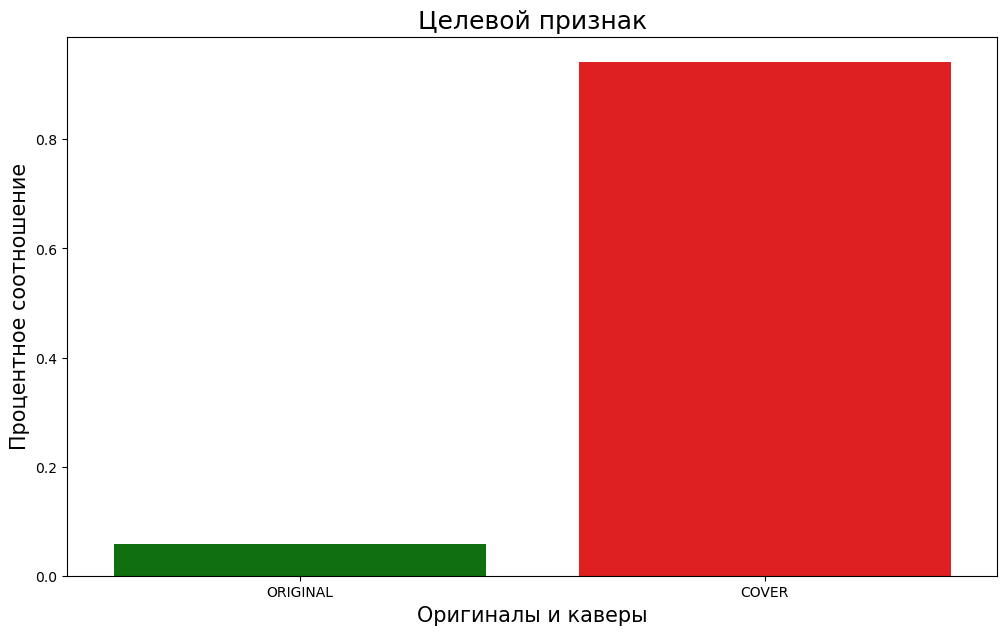

Обработка завершена


In [32]:
data = preprocess_dataset(data=data)

**Информация по датасету**

In [33]:
display_dataset_info(data)

-----------------------------------SAMPLE-----------------------------------


,isrc,title,genres,year,language_text,dttm,duration,text,track_remake_type
0,USFI86900049,Proud Mary,"ROCK, ALLROCK",1969,EN,1.257973e+12,187220.0,left a good job in the city workin' for the man ev'ry night and day and i never lost one minute ...,1
2,USFI86900065,Fortunate Son,"ROCK, ALLROCK",1969,EN,1.257973e+12,137780.0,some folks are born made to wave the flag ooh they're red white and blue and when the band plays...,1
3,USUL10400965,La Camisa Negra,"POP, FOLK, LATINFOLK",2004,ES,1.253563e+12,216840.0,uno por pobre y feo hombre pero antoja'o ay ome tengo la camisa negra hoy mi amor está de luto h...,1
4,USUM70722806,The Way I Are,"FOREIGNRAP, RAP",2007,EN,1.258405e+12,179660.0,yeah yeah remember the time baby yeah i ain't got no money i ain't got no car to take you on a d...,1
8,FR8Q10900116,Extraball,ELECTRONICS,2009,EN,1.253218e+12,212620.0,now i try to walk and talk i need the extraball it's purely physical i think your time is now i ...,0



------------------------------------INFO------------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71115 entries, 0 to 72570
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   isrc               71115 non-null  category
 1   title              71115 non-null  category
 2   genres             71115 non-null  category
 3   year               71115 non-null  category
 4   language_text      71115 non-null  category
 5   dttm               71115 non-null  float64 
 6   duration           71115 non-null  float64 
 7   text               71115 non-null  object  
 8   track_remake_type  71115 non-null  int64   
dtypes: category(5), float64(2), int64(1), object(1)
memory usage: 7.5+ MB


None

----------------------------------DESCRIBE----------------------------------


,isrc,title,genres,year,language_text,dttm,duration,text,track_remake_type
count,71115,71115,71115,71115.0,71115,7.111500e+04,7.111500e+04,71115,71115.000000
unique,71115,45175,229,77.0,52,NaN,NaN,40248,NaN
top,AEA0D1828626,Morena,"FOLK, LATINFOLK",2021.0,EN,NaN,NaN,no text,NaN
freq,1,81,18381,24976.0,33541,NaN,NaN,3095,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.584904e+12,2.048968e+05,NaN,0.059003
std,NaN,NaN,NaN,NaN,NaN,9.077109e+10,8.570279e+04,NaN,0.235632
min,NaN,NaN,NaN,NaN,NaN,1.249926e+12,0.000000e+00,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,1.572515e+12,1.612300e+05,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,1.620641e+12,1.993200e+05,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,1.637160e+12,2.390450e+05,NaN,0.000000


<div style="border:solid green 2px; padding: 20px">
    
*Точка сохранения №2. Сохранение финального датасета.* 

**Сохранение финального датасета**

In [34]:
data.to_pickle(os.path.join(work_dir, "data_final"), compression="zip")

<div style="border:solid green 2px; padding: 20px">
    
*Точка восстановления №2. Загрузка финального датасета.*

**Сбор мусора**

In [35]:
gc.collect()

2749

**Загрузка финального датасета**

In [36]:
data = pd.read_pickle(os.path.join(work_dir, "data_final"), compression="zip")

## Классификационная модель 

**Получение масштабированных выборок (вызов функции `get_selections`)**

In [37]:
features_train, target_train, features_test, target_test = get_selections(
    dataset=data, target_col="track_remake_type", cols_to_drop=["text", "title"], test_size=0.25
)

**Перебор гиперпараметров и получение обученной модели (вызов функции `get_model_with_best_params`)**

<div style="border:solid green 2px; padding: 20px">
    
*Гиперпараметры модели будут подобраны с помощью `Optuna` с кроссвалидацией.*
    
*Т.к в датасете присутствую дисбаланс классов, в качестве метрики выбрана `ROC-AUC`, как наименее критичная к дисбалансу классов.*  
    
*Как альтернативу можно взять метрику `PR AUC`.*     

In [38]:
best_model = get_model_with_best_params(
    n_trials=10, features_train=features_train, target_train=target_train
)

[I 2023-11-15 11:36:15,171] A new study created in memory with name: lightgbm
[I 2023-11-15 11:36:22,112] Trial 0 finished with value: 0.9748031204801565 and parameters: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 265, 'max_depth': 6, 'num_leaves': 15, 'min_child_weight': 16.910894059585033, 'subsample': 0.9822572598678108, 'subsample_freq': 5, 'pos_subsample': 0.8748906637533912, 'neg_subsample': 0.6960709612555206, 'learning_rate': 0.17504287097416255, 'reg_alpha': 9.616936687120932, 'reg_lambda': 0.18304414962137955, 'scale_pos_weight': 6.425777506790878}. Best is trial 0 with value: 0.9748031204801565.
[I 2023-11-15 11:36:37,714] Trial 1 finished with value: 0.940251244476395 and parameters: {'objective': 'binary', 'boosting_type': 'rf', 'n_estimators': 829, 'max_depth': 22, 'num_leaves': 25, 'min_child_weight': 19.47370693839907, 'subsample': 0.8212376639479206, 'subsample_freq': 6, 'pos_subsample': 0.8467599007219296, 'neg_subsample': 0.5976754032618133, 'lea


Лучшие гиперпараметры подобраные Optuna: {'objective': 'binary', 'boosting_type': 'gbdt', 'n_estimators': 276, 'max_depth': 8, 'num_leaves': 17, 'min_child_weight': 6.724462102455043, 'subsample': 0.5714725099061049, 'subsample_freq': 4, 'pos_subsample': 0.8689341329658298, 'neg_subsample': 0.7569877432369667, 'learning_rate': 0.08751551442660815, 'reg_alpha': 5.858024887754325, 'reg_lambda': 7.140047955474751, 'scale_pos_weight': 7.009667428186099}
Усредненная метрика AUC-ROC модели на тренировочной выборке с кроссвалидацией: 0.9759348936556712
Модель LGBMClassifier обучена.


**Предсказание модели на тестовой выборке (вызов функции `get_test_metric`)**

In [39]:
get_test_metric(model=best_model, features_test=features_test, target_test=target_test)

Метрика AUC-ROC модели на тестовой выборке: 0.9776
PR AUC:  0.801675962522173


**Создаем матрицу ошибок.**

In [40]:
conf_matrix = confusion_matrix(target_test, best_model.predict(features_test))

**Выводим матрицу на экран (вызов функции `drow_confusion_matrix`).**

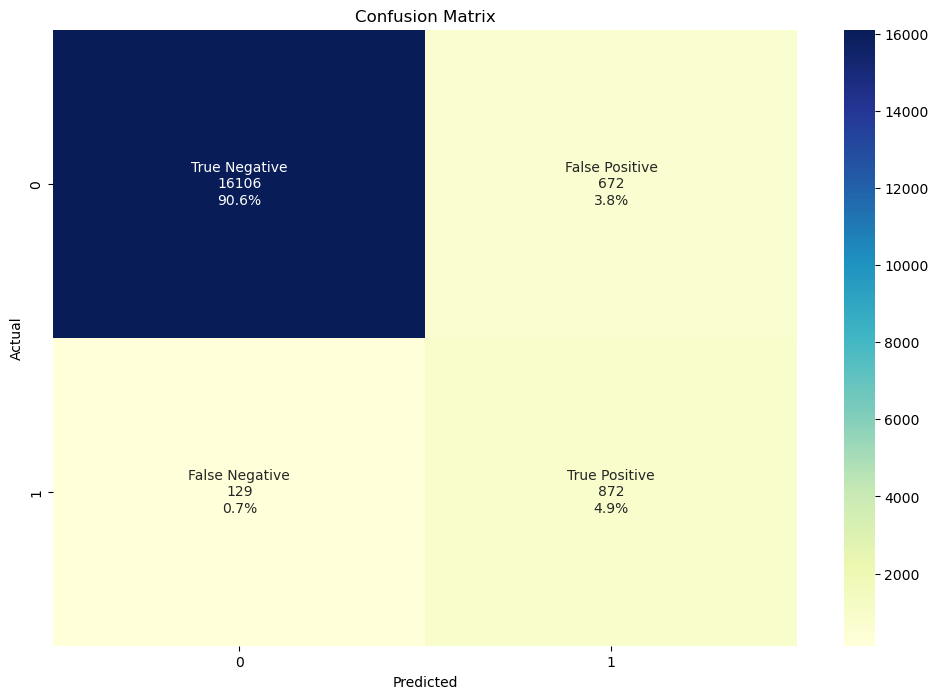

In [41]:
drow_confusion_matrix(conf_matrix)

**Результат (вызов функции `conf_matrix_result`).**

In [42]:
conf_matrix_result(conf_matrix)

Всего предсказаний: 17779

Правильно предсказанные ответы (Accuracy): 0.9549
Ошибки в прогнозах: 0.0451

Recall: 0.8711
Precision: 0.5648

Доля ошибок в оригиналах FN/TP: 0.15
Доля ошибок в каверах FP/TN: 0.04

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:

  - TN в левом верхнем углу. 16106 правильных ответов. Кавер определен правильно.
  - TP в правом нижнем углу. 872 правильных ответов. Оригинал определен правильно.

2. Вне главной диагонали — ошибочные варианты:

  - FP в правом верхнем углу. 672 ошибок ошибочных предсказаний первого рода. Кавер определен как оригинал.
  - FN в левом нижнем углу. 129 ошибочных предсказаний второго рода. Оригинал определен как кавер.


В датасете присутствует дисбаланс классов, при подборе параметров пришлось придавать значимость (гиперпараметр `scale_pos_weight`) позитивному классу. За счет этого увеличилась ошибка 1 рода, и уменьшилась ошибка 2-го рода. Можно пробовать тунить далее за счет трешхолда, но этот путь увеличит количетсво ошибок в прогнозировании оригиналов.

**PR-кривая (вызов функции `drow_pr_curve`).**

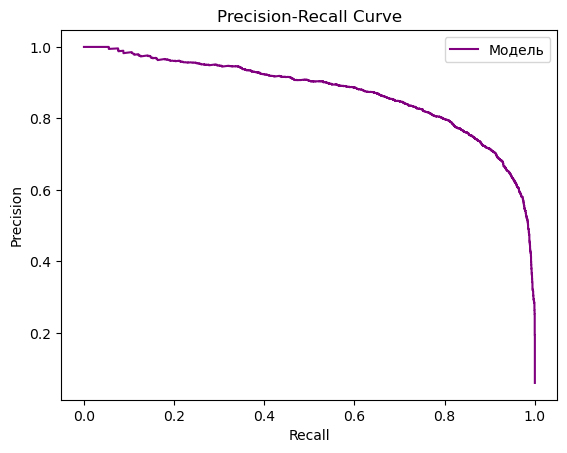

In [43]:
drow_pr_curve(features_train, target_train, best_model, treshold=False)

**Сбор мусора**

In [44]:
gc.collect()

3509

## Модель нахождения кавер-треков и/или исходников к заданному треку в датасете

В модуле SentenceTransformer есть предобученная модель `sentence-transformers/LaBSE`, которая воспринимает много языков и создаёт эмбединги так, что при сравнении например одного слова на разных языках вектора этих слов будут максимально близки.

[LaBSE](https://huggingface.co/sentence-transformers/LaBSE)

В поиске кавер-треков и/или исходников к заданному треку в датасете будут использованы след. методы.

- получение эмбеддингов по всем текстам песен в датасете,
- по имени трека, получение эмбеддинга текста песни,
- проведение семантического анализа ветора текста песни со всеми векторами песен в датасете,
- выбор текстов с наибольшей семантической близостью,
- проведение классификаци кавер/оригинал,
- вывод списка кавер/оригинал,
- поиск оригинала, его нет в списке.

**Провека наличия `GPU`**

In [45]:
# проверяем наличие gpu
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

**Инициализация модели**

In [46]:
model = SentenceTransformer("sentence-transformers/LaBSE")

**Векторизация**

<div style="border:solid green 2px; padding: 20px">
    
*Данный этап можно пропустить, т.к эмбеддинги делаются долго  и их можно загрузить ниже из pickle файла.* 

In [47]:
embedding_all_texts = model.encode(list(data["text"]),
                                   show_progress_bar=True,
                                   device=device,
                                   batch_size=4)

<div style="border:solid green 2px; padding: 20px">
    
*Точка сохранения №3. Сохранение векторов текстов песен.* 

**Сохранение эмбеддингов**

In [48]:
with open(os.path.join(work_dir, "embedding_all_texts.pickle"), "wb") as file:
    pickle.dump(embedding_all_texts, file)

**Сбор мусора и очистка кэша `CUDA`**

In [49]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()

<div style="border:solid green 2px; padding: 20px">
    
*Точка восстановления №3. Загрузка векторов текстов песен.*

**Загрузка эмбеддингов**

In [50]:
with open(os.path.join(work_dir, "embedding_all_texts.pickle"), "rb") as file:
    embedding_all_texts = pickle.load(file)

In [51]:
embedding_all_texts.shape

(71115, 768)

**Проверка работы функции `search_covers` для разных треков**

,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,USPR39330175,I Was Made For Lovin' You,"ROCK, CLASSICMETAL, METAL, HARDROCK, ALLROCK",1993,ORIGINAL,ORIGINAL,KISS
1,USUM71406149,I Was Made For Lovin' You,"HARDROCK, ALLROCK",2014,ORIGINAL,ORIGINAL,KISS
2,QZNJX2234842,I Was Made for Lovin You,ALTERNATIVE,2022,COVER,COVER,Unknown



В имеющейся базе данных найдено 3 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - USPR39330175, Название - I Was Made For Lovin' You, Исполнитель - KISS
Тип песни - ORIGINAL, Тип предсказанный моделью - ORIGINAL
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - USUM71406149, Название - I Was Made For Lovin' You, Исполнитель - KISS
Тип песни - ORIGINAL, Тип предсказанный моделью - ORIGINAL
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - QZNJX2234842, Название - I Was Made for Lovin You, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

В имеющейся базе данных есть оригинал трека.

Информациою по оригиналу можно взять с сайта https://genius.com

Searching for "I Was Made For Lovin' You"...
Done.
Исполнитель: KISS. Трек: I Was Made for Lovin’ You


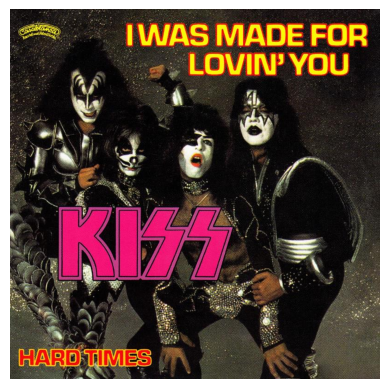

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [52]:
search_covers(song_name="I Was Made For Lovin' You")

Здесь все спрогнозированно правильно.

,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,ES64A1007801,Yesterday,POP,2010,COVER,COVER,Unknown
1,USA560672077,Yesterday,"ROCK, ALLROCK",2006,COVER,COVER,Unknown
2,USA560898050,Yesterday,CHILDREN,2008,COVER,COVER,Unknown
3,FRZ020580550,Yesterday,JAZZ,2005,COVER,COVER,Unknown
4,DEU240900656,Yesterday,"ROCK, ALLROCK",2009,COVER,COVER,Unknown
5,USA560628330,Yesterday,ELECTRONICS,2006,COVER,COVER,Unknown
6,USA560898478,Yesterday,"FOLK, LATINFOLK",2008,COVER,COVER,Unknown
7,DEU241075882,Yesterday,POP,2010,COVER,ORIGINAL,Unknown
8,USA560685275,Yesterday,POP,2006,COVER,COVER,Unknown
9,USGR10500142,Yesterday,JAZZ,2005,COVER,COVER,Unknown



В имеющейся базе данных найдено 10 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - ES64A1007801, Название - Yesterday, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - USA560672077, Название - Yesterday, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - USA560898050, Название - Yesterday, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - FRZ020580550, Название - Yesterday, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - DEU240900656, Название - Yesterday, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Мод

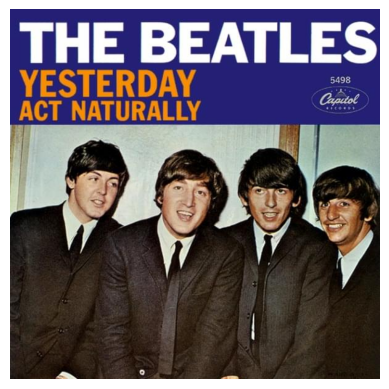

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [53]:
search_covers(song_name="Yesterday")

,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,SEBKB9429100,Sabbath Bloody Sabbath,"POP, ROCK, ALLROCK",1994,COVER,COVER,The Cardigans



В имеющейся базе данных найдено 1 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - SEBKB9429100, Название - Sabbath Bloody Sabbath, Исполнитель - The Cardigans
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

В имеющейся базе данных нет оригинала трека.
Возможный оригинал будет взят с сайта https://genius.com

Searching for "Sabbath Bloody Sabbath"...
Done.
Исполнитель: Black Sabbath. Трек: Sabbath Bloody Sabbath


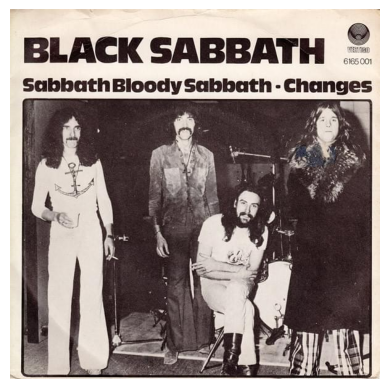

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [54]:
search_covers(song_name="Sabbath Bloody Sabbath")

,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,USUL10400965,La Camisa Negra,"POP, FOLK, LATINFOLK",2004,ORIGINAL,ORIGINAL,Juanes
1,PLS921752779,La Camisa Negra,UNKNOWN,2017,COVER,COVER,Unknown
2,ES20I1176821,La Camisa Negra,"FOLK, LATINFOLK",2011,COVER,COVER,Unknown
3,FR2X41525049,La Camisa Negra,UNKNOWN,2015,COVER,COVER,Unknown
4,PLS921752737,La Camisa Negra,UNKNOWN,2017,COVER,COVER,Unknown
5,PLS921752652,La Camisa Negra,UNKNOWN,2017,COVER,COVER,Unknown
6,QZHZ42168989,La Camisa Negra,"FOLK, LATINFOLK",2021,COVER,COVER,Unknown
7,PLS921752697,La Camisa Negra,UNKNOWN,2017,COVER,COVER,Unknown



В имеющейся базе данных найдено 8 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - USUL10400965, Название - La Camisa Negra, Исполнитель - Juanes
Тип песни - ORIGINAL, Тип предсказанный моделью - ORIGINAL
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - PLS921752779, Название - La Camisa Negra, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - ES20I1176821, Название - La Camisa Negra, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - FR2X41525049, Название - La Camisa Negra, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - PLS921752737, Название - La Camisa Negra, Исполнитель - Unknown
Тип песни - COVER, Тип

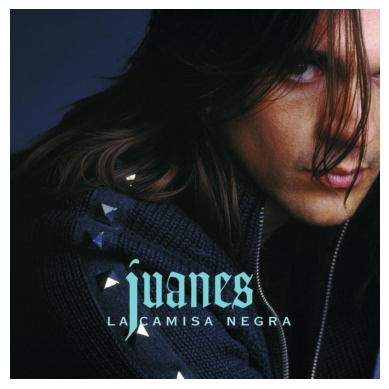

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [55]:
search_covers(song_name="La Camisa Negra")

,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,USMC16846563,Born To Be Wild,"HARDROCK, ALLROCK",1968,COVER,COVER,Steppenwolf
1,FR6V82414213,Born to Be Wild,"CLASSICMETAL, METAL",1924,COVER,COVER,Unknown
2,GBAJE8300113,Born to Be Wild,"CLASSICMETAL, METAL",1983,COVER,COVER,Unknown
3,QZGLM2110467,Born to Be Wild,"ROCK, ALLROCK",2021,COVER,COVER,Unknown
4,ITDD82016947,Born to be wild,DANCE,2020,COVER,COVER,Unknown
5,QZPJ32145439,Born to be Wild,"ROCK, ALLROCK",2021,COVER,COVER,Unknown
6,QZGLS2265423,Born to Be Wild,"ROCK, ALLROCK",2022,COVER,COVER,Unknown
7,QZMZ92233321,Born To Be Wild,"ROCK, ALLROCK",2022,COVER,COVER,Unknown
8,TCABU1465101,Born to Be Wild,"ROCK, ALLROCK",2014,COVER,COVER,Unknown
9,DEH841400620,Born to Be Wild,"ROCK, ALLROCK",2014,COVER,COVER,Unknown



В имеющейся базе данных найдено 10 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - USMC16846563, Название - Born To Be Wild, Исполнитель - Steppenwolf
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - FR6V82414213, Название - Born to Be Wild, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - GBAJE8300113, Название - Born to Be Wild, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - QZGLM2110467, Название - Born to Be Wild, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - ITDD82016947, Название - Born to be wild, Исполнитель - Unknown
Тип песни - COVER, Тип

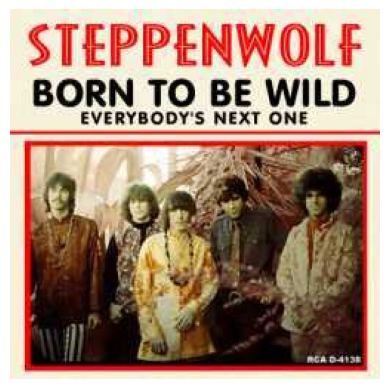

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [56]:
search_covers(song_name="Born To Be Wild")

А вот тут интересный момент, весь прогноз правильный, но изначальная разметка видимо ошибочна. Исполнитель: Steppenwolf. Трек: Born to Be Wild это оригинал, но в базе помечен, как кавер.

,isrc,title,genres,year,track_remake_type,track_remake_type_preds,artist
0,PLS921748325,Knockin' on Heaven's Door,UNKNOWN,2017,COVER,COVER,Unknown
1,USGF19142004,Knockin' On Heaven's Door,"ROCK, HARDROCK, ALLROCK",1991,COVER,COVER,Guns N’ Roses
2,PLS921748449,Knockin' on Heaven's Door,UNKNOWN,2017,COVER,COVER,Unknown
3,PLS921748407,Knockin' on Heaven's Door,UNKNOWN,2017,COVER,COVER,Unknown
4,PLS921748365,Knockin' on Heaven's Door,RELAX,2017,COVER,COVER,Unknown
5,UKN492000321,Knockin' On Heavens Door,ALTERNATIVE,2020,COVER,COVER,Unknown
6,BCCZR2022418,Knockin' On Heaven's Door,"ROCK, ALLROCK",2020,COVER,COVER,Unknown
7,QZGWX2092411,Knockin' on Heaven's Door,"ROCK, ALLROCK",2020,COVER,COVER,Unknown
8,QZGLM1957034,Knockin' On Heaven's Door,"ROCK, ALLROCK",2019,COVER,COVER,Unknown
9,USJCH1200315,Knockin On Heavens Door,"ROCK, ALLROCK",2012,COVER,COVER,Unknown



В имеющейся базе данных найдено 10 трека(ов).
Поиск имён исполнителей осуществлялся по коду isrc на musicbrainzngs.
К сожалению не все коды есть в базе сайта...

Трек 1: Код isrc - PLS921748325, Название - Knockin' on Heaven's Door, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 2: Код isrc - USGF19142004, Название - Knockin' On Heaven's Door, Исполнитель - Guns N’ Roses
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 3: Код isrc - PLS921748449, Название - Knockin' on Heaven's Door, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 4: Код isrc - PLS921748407, Название - Knockin' on Heaven's Door, Исполнитель - Unknown
Тип песни - COVER, Тип предсказанный моделью - COVER
Модель правильно классифицировала тип трека.

Трек 5: Код isrc - PLS921748365, Название - Knockin' on Heaven'

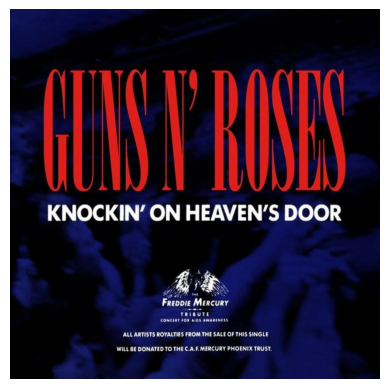

К сожалению не все треки и изображения можно найти на сате https://genius.com


In [57]:
search_covers(song_name="Knockin' on Heaven's Door")

Аналогично, весь прогноз правильный, но изначальная разметка видимо ошибочна. Исполнитель: Guns N’ Roses. Трек: Knockin’ on Heaven’s Door это оригинал, но в базе помечен, как кавер.

## Выводы

В результате исследования были построены 2 модели:

- модель классификации,
- модель нахождения кавер-треков и/или исходников к заданному треку в датасете.

Классификация проводилась на основе метаданных. 

Итоговая метрика около 0.98. 

Модель нахождения кавер-треков и/или исходников к заданному треку находит задынный трек и выводит список нужных треков.

К сожаленю не все данные удалость вытащить из открытых источников, т.к. из там либо нету, либо доступ закрыт, либо они платные. 

В результате поиска каверов были обнаружены недочеты в изначальной разметке.